# Calculate biogenesis and accumulation rates

In [1]:
#install.packages("scales")

In [2]:


if(!require("pacman")) {
    install.packages("pacman", dependencies = TRUE,
                     repos = "http://cloud.r-project.org/")
  }

  p_load(rlang)


  p_install_version(
    c("rlang", "tidyverse", "cowplot", "Biostrings", "Rsamtools",
      "BiocParallel", "jsonlite"),
    c("0.2.1", "1.2.1", "0.9.2", "2.44.2", "1.28.0", "1.10.1", "1.5")
  )

  # Load Tidyverse as late as possible to overload `filter`, `select` and `rename` functions
  pacman::p_load(Biostrings, Rsamtools, BiocParallel, rlang,
                 tidyverse, cowplot, jsonlite)



library(tidyverse)
library(dplyr)
library(Rsamtools)
library('IRanges')
library('chromstaR')
library(ShortRead)
library(rtracklayer)
library('GenomicAlignments')


library(broom)
library(minpack.lm)
library(nlsr)
library(gplots)
library(ggplot2)
library(gplots)
library(cowplot)
library(scales)

Loading required package: pacman


Version of rlang (v. 0.4.7) is suitable


Version of tidyverse (v. 1.3.0) is suitable


Version of cowplot (v. 1.0.0) is suitable


Version of Biostrings (v. 2.54.0) is suitable


Version of Rsamtools (v. 2.2.3) is suitable


Version of BiocParallel (v. 1.20.1) is suitable


Version of jsonlite (v. 1.6.1) is suitable

Loading required package: chromstaRData


Please visit https://github.com/ataudt/chromstaR for the latest bugfixes and features.


Loading required package: GenomicAlignments

Loading required package: SummarizedExperiment

Loading required package: Biobase

Welcome to Bioconductor

    Vignettes contain introductory material; view with
    'browseVignettes()'. To cite Bioconductor, see
    'citation("Biobase")', and for packages 'citation("pkgname")'.



Attaching package: ‘Biobase’


The following object is masked from ‘package:rlang’:

    exprs


Loading required package: DelayedArray

Loading required package: matrixStats


Attachin

In [3]:
options(stringsAsFactors = FALSE)
rm(list = ls())

In [4]:
col_shgfp <- "gray30"
col_sh6 <- '#FDAE61'
col_sh11 <- '#3288BD'

# read files in

In [3]:
# files deposited in GEO: accession number GSE178127
fits.gfp <- read.delim("/timecourse_merge_gfp_for_heatmap_accumulation_plot.tsv")
fits.6 <- read.delim("/timecourse_mergeRepl_sh6_for_heatmap_accumulation_plot.tsv")
fits.11 <- read.delim("/timecourse_sh11_for_heatmap_accumulation_plot.tsv")

In [10]:
# only look at the 64 mature and star mirs:
# provided in github Shiekhattarlab/miRNApaper/s4U_figures/32_miRNA_couples_toAnalyze.txt
mi <- read.delim("32_miRNA_couples_toAnalyze.txt", header=F)
colnames(mi) <- c("arm.name", "mir.type")

mi$mir.type <- gsub("star", "passenger", mi$mir.type)
mi$mir.type <- gsub("mature", "guide", mi$mir.type)
head(mi)

Warning message in file(file, "rt"):
“cannot open file '32_miRNA_couples_toAnalyze.txt': No such file or directory”


ERROR: Error in file(file, "rt"): cannot open the connection


In [14]:
set.seed(100)

In [18]:
head(fits.gfp, n=3)

fits.gfp <- fits.gfp %>%
    select(-c(mir.type,flybase_id, start.pos, average.ppm, seed, UCount, totalReads, duplex,  
            avg.tc.pct, )) %>% # remove Reichholf calc and all the stuff I don't care about
    left_join(m, by="arm.name") %>%
    filter(!is.na(mir.type))

fits.6 <- fits.6 %>%
    select(-c(mir.type,flybase_id, start.pos, average.ppm, seed, UCount, totalReads, duplex, 
            avg.tc.pct)) %>% # remove Reichholf calc and all the stuff I don't care about
    left_join(m, by="arm.name") %>%
    filter(!is.na(mir.type))


fits.11 <- fits.11 %>%
    select(-c(mir.type,flybase_id, start.pos, average.ppm, seed, UCount, totalReads, duplex, 
            avg.tc.pct)) %>% # remove Reichholf calc and all the stuff I don't care about
    left_join(m, by="arm.name") %>%
    filter(!is.na(mir.type))

head(fits.gfp)

,flybase_id,duplex,arm.name,start.pos,mir.type,UCount,seed,time,totalReads,average.ppm,avg.tc.pct,avg.tc.ppm
,<chr>,<chr>,<chr>,<int>,<chr>,<int>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,chr7:99691162-99691266,miR-25,miR-25-3p,52,mature,7,CATTGCAC,0.00,1124.631,1195.731,0.04020073,0.4806925
2,chr7:99691162-99691266,miR-25,miR-25-3p,52,mature,7,CATTGCAC,0.25,1068.352,1195.731,0.04904787,0.5864804
3,chr7:99691162-99691266,miR-25,miR-25-3p,52,mature,7,CATTGCAC,0.50,1164.058,1195.731,0.04634413,0.5541510


,arm.name,time,avg.tc.ppm,mir.type
,<chr>,<dbl>,<dbl>,<chr>
1,miR-25-3p,0,0.4806925,guide
2,miR-25-3p,0,0.4806925,guide
3,miR-25-3p,0,0.4806925,guide
4,miR-25-3p,0,0.4806925,guide
5,miR-25-3p,0,0.4806925,guide
6,miR-25-3p,0,0.4806925,guide


In [19]:
# need to remove background
bg.gfp <- fits.gfp %>%
    filter(time == 0) %>%
    dplyr::rename(bg.tc.mut=avg.tc.ppm)

head(bg.gfp)

,arm.name,time,bg.tc.mut,mir.type
,<chr>,<dbl>,<dbl>,<chr>
1,miR-25-3p,0,0.4806925,guide
2,miR-25-3p,0,0.4806925,guide
3,miR-25-3p,0,0.4806925,guide
4,miR-25-3p,0,0.4806925,guide
5,miR-25-3p,0,0.4806925,guide
6,miR-25-3p,0,0.4806925,guide


In [20]:
# need to remove background
bg.gfp <- fits.gfp %>%
    filter(time == 0) %>%
    dplyr::rename(bg.tc.mut=avg.tc.ppm) %>%
    select(-time)

bg.6 <- fits.6 %>%
    filter(time == 0) %>%
    dplyr::rename(bg.tc.mut=avg.tc.ppm) %>%
    select(-time)

bg.11 <- fits.11 %>%
    filter(time == 0) %>%
    dplyr::rename(bg.tc.mut=avg.tc.ppm) %>%
    select(-time)


In [21]:
# remove background and timepoint 5min
fits.gfp <- fits.gfp %>%
    filter(time > 0.083) %>%
    left_join(bg.gfp, by=c("arm.name", "mir.type")) %>%
    group_by(arm.name) %>%
    mutate(tc.ppm.minus.mut = ifelse(bg.tc.mut < avg.tc.ppm, avg.tc.ppm-bg.tc.mut, 0)) %>%
    select(-c(bg.tc.mut, avg.tc.ppm)) %>%
    dplyr::rename(avg.tc.ppm = tc.ppm.minus.mut)
fits.gfp <- fits.gfp[!duplicated(fits.gfp),]

fits.6 <- fits.6 %>%
    filter(time > 0.083) %>%
    left_join(bg.6, by=c("arm.name", "mir.type")) %>%
    group_by(arm.name) %>%
    mutate(tc.ppm.minus.mut = ifelse(bg.tc.mut < avg.tc.ppm, avg.tc.ppm-bg.tc.mut, 0)) %>%
    select(-c(bg.tc.mut, avg.tc.ppm)) %>%
    dplyr::rename(avg.tc.ppm = tc.ppm.minus.mut)    
fits.6 <- fits.6[!duplicated(fits.6),]


fits.11 <- fits.11 %>%
    filter(time > 0.083) %>%
    left_join(bg.11, by=c("arm.name", "mir.type")) %>%
    group_by(arm.name) %>%
    mutate(tc.ppm.minus.mut = ifelse(bg.tc.mut < avg.tc.ppm, avg.tc.ppm-bg.tc.mut, 0)) %>%
    select(-c(bg.tc.mut, avg.tc.ppm)) %>%
    dplyr::rename(avg.tc.ppm = tc.ppm.minus.mut)    
fits.11 <- fits.11[!duplicated(fits.11),]

In [22]:
# define upper threshold
# as we also observe loss of miRNA in late time points, I would only use up to 6/12h
limit = 6

fits.gfp.bio.mature <- fits.gfp %>%
    filter(time <= 1, mir.type=="guide")

fits.gfp.bio.star <- fits.gfp %>%
    filter(time <= 1, mir.type=="passenger")

fits.gfp.accu.mature <- fits.gfp %>%
    filter(time >= 1 & time <= limit , mir.type=="guide")

fits.gfp.accu.star <- fits.gfp %>%
    filter(time >= 1 & time <= limit, mir.type=="passenger")



fits.6.bio.mature <- fits.6 %>%
    filter(time <= 1, mir.type=="guide")

fits.6.bio.star <- fits.6 %>%
    filter(time <= 1, mir.type=="passenger")

fits.6.accu.mature <- fits.6 %>%
    filter(time >= 1 & time <= limit, mir.type=="guide")

fits.6.accu.star <- fits.6 %>%
    filter(time >= 1 & time <= limit, mir.type=="passenger")



fits.11.bio.mature <- fits.11 %>%
    filter(time <= 1, mir.type=="guide")

fits.11.bio.star <- fits.11 %>%
    filter(time <= 1, mir.type=="passenger")

fits.11.accu.mature <- fits.11 %>%
    filter(time >= 1 & time <= limit, mir.type=="guide")

fits.11.accu.star <- fits.11 %>%
    filter(time >= 1 & time <= limit, mir.type=="passenger")

In [23]:
head(fits.gfp.bio.mature)
unique(fits.gfp.bio.mature$time)
unique(fits.gfp.accu.mature$time)

arm.name,time,mir.type,avg.tc.ppm
<chr>,<dbl>,<chr>,<dbl>
miR-25-3p,0.25,guide,0.10578792
miR-25-3p,0.50,guide,0.07345855
miR-25-3p,1.00,guide,0.23020816
let-7d-5p,0.25,guide,0.00000000
let-7d-5p,0.50,guide,0.06343105
let-7d-5p,1.00,guide,0.14667281


[1] 0.25 0.50 1.00

[1] 1 3 6

# linear fits

### shGFP

In [24]:
# biogenesis
lm.gfp.bio.mature <- lm(avg.tc.ppm ~ time, data= fits.gfp.bio.mature)
lm.gfp.bio.mature$coefficients[2]
summary(lm.gfp.bio.mature)

lm.gfp.bio.star <- lm(avg.tc.ppm ~ time, data= fits.gfp.bio.star)
lm.gfp.bio.star$coefficients[2]
summary(lm.gfp.bio.star)


# accumulation
lm.gfp.accu.mature <- lm(avg.tc.ppm ~ time, data= fits.gfp.accu.mature)
lm.gfp.accu.mature$coefficients[2]
summary(lm.gfp.accu.mature)

lm.gfp.accu.star <- lm(avg.tc.ppm ~ time, data= fits.gfp.accu.star)
lm.gfp.accu.star$coefficients[2]
summary(lm.gfp.accu.star)

time 
0.06654407


Call:
lm(formula = avg.tc.ppm ~ time, data = fits.gfp.bio.mature)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.05462 -0.02134 -0.00471  0.00252  0.57818 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)   
(Intercept) -0.01193    0.01592  -0.749  0.45552   
time         0.06654    0.02406   2.765  0.00689 **
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.07236 on 91 degrees of freedom
Multiple R-squared:  0.07752,	Adjusted R-squared:  0.06738 
F-statistic: 7.647 on 1 and 91 DF,  p-value: 0.006886


time 
0.07416602


Call:
lm(formula = avg.tc.ppm ~ time, data = fits.gfp.bio.star)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.05758 -0.03518 -0.01111 -0.00151  0.88078 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)  
(Intercept) -0.01658    0.02278  -0.728   0.4685  
time         0.07417    0.03444   2.153   0.0339 *
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.1036 on 91 degrees of freedom
Multiple R-squared:  0.04848,	Adjusted R-squared:  0.03803 
F-statistic: 4.637 on 1 and 91 DF,  p-value: 0.03394


time 
0.1772654


Call:
lm(formula = avg.tc.ppm ~ time, data = fits.gfp.accu.mature)

Residuals:
    Min      1Q  Median      3Q     Max 
-0.9300 -0.3877 -0.0658 -0.0039  6.6392 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) -0.11912    0.19773  -0.602 0.548378    
time         0.17727    0.05049   3.511 0.000698 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 1.001 on 91 degrees of freedom
Multiple R-squared:  0.1193,	Adjusted R-squared:  0.1096 
F-statistic: 12.32 on 1 and 91 DF,  p-value: 0.0006977


time 
0.0397792


Call:
lm(formula = avg.tc.ppm ~ time, data = fits.gfp.accu.star)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.26784 -0.13053 -0.06895 -0.02319  1.80720 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)  
(Intercept)  0.02917    0.06382   0.457   0.6488  
time         0.03978    0.01630   2.441   0.0166 *
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.323 on 91 degrees of freedom
Multiple R-squared:  0.06143,	Adjusted R-squared:  0.05112 
F-statistic: 5.956 on 1 and 91 DF,  p-value: 0.0166


### shINTS6

In [25]:
# biogenesis
lm.6.bio.mature <- lm(avg.tc.ppm ~ time, data= fits.6.bio.mature)
lm.6.bio.mature$coefficients[2]
summary(lm.6.bio.mature)


lm.6.bio.star <- lm(avg.tc.ppm ~ time, data= fits.6.bio.star)
lm.6.bio.star$coefficients[2]
summary(lm.6.bio.star)

# accumulation
lm.6.accu.mature <- lm(avg.tc.ppm ~ time, data= fits.6.accu.mature)
lm.6.accu.mature$coefficients[2]
summary(lm.6.accu.mature)

lm.6.accu.star <- lm(avg.tc.ppm ~ time, data= fits.6.accu.star)
lm.6.accu.star$coefficients[2]
summary(lm.6.accu.star)

time 
0.07630145


Call:
lm(formula = avg.tc.ppm ~ time, data = fits.6.bio.mature)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.05871 -0.02056 -0.00711 -0.00004  0.50969 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)   
(Intercept) -0.01759    0.01661  -1.059   0.2923   
time         0.07630    0.02511   3.039   0.0031 **
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.0755 on 91 degrees of freedom
Multiple R-squared:  0.09213,	Adjusted R-squared:  0.08215 
F-statistic: 9.235 on 1 and 91 DF,  p-value: 0.0031


time 
0.1794463


Call:
lm(formula = avg.tc.ppm ~ time, data = fits.6.bio.star)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.13395 -0.09182 -0.04202  0.00063  2.39113 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)  
(Intercept) -0.04549    0.06143  -0.741   0.4609  
time         0.17945    0.09288   1.932   0.0565 .
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.2793 on 91 degrees of freedom
Multiple R-squared:  0.0394,	Adjusted R-squared:  0.02885 
F-statistic: 3.733 on 1 and 91 DF,  p-value: 0.05647


time 
0.0724022


Call:
lm(formula = avg.tc.ppm ~ time, data = fits.6.accu.mature)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.43694 -0.20733 -0.07493 -0.00995  2.59988 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)   
(Intercept) 0.002524   0.093600   0.027  0.97854   
time        0.072402   0.023903   3.029  0.00319 **
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.4737 on 91 degrees of freedom
Multiple R-squared:  0.09159,	Adjusted R-squared:  0.0816 
F-statistic: 9.175 on 1 and 91 DF,  p-value: 0.003193


time 
0.03815241


Call:
lm(formula = avg.tc.ppm ~ time, data = fits.6.accu.star)

Residuals:
    Min      1Q  Median      3Q     Max 
-0.3641 -0.2481 -0.1733 -0.1410  4.6646 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)
(Intercept)  0.13515    0.15607   0.866    0.389
time         0.03815    0.03986   0.957    0.341

Residual standard error: 0.7898 on 91 degrees of freedom
Multiple R-squared:  0.009969,	Adjusted R-squared:  -0.0009104 
F-statistic: 0.9163 on 1 and 91 DF,  p-value: 0.341


### shINTS11

In [26]:
# biogenesis
lm.11.bio.mature <- lm(avg.tc.ppm ~ time, data= fits.11.bio.mature)
lm.11.bio.mature$coefficients[2]
summary(lm.11.bio.mature)


lm.11.bio.star <- lm(avg.tc.ppm ~ time, data= fits.11.bio.star)
lm.11.bio.star$coefficients[2]
summary(lm.11.bio.star)

# accumulation
lm.11.accu.mature <- lm(avg.tc.ppm ~ time, data= fits.11.accu.mature)
lm.11.accu.mature$coefficients[2]
summary(lm.11.accu.mature)

lm.11.accu.star <- lm(avg.tc.ppm ~ time, data= fits.11.accu.star)
lm.11.accu.star$coefficients[2]
summary(lm.11.accu.star)

time 
0.03502607


Call:
lm(formula = avg.tc.ppm ~ time, data = fits.11.bio.mature)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.02982 -0.01231 -0.00355  0.00170  0.13003 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) -0.005206   0.006177  -0.843  0.40150    
time         0.035026   0.009338   3.751  0.00031 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.02808 on 91 degrees of freedom
Multiple R-squared:  0.1339,	Adjusted R-squared:  0.1244 
F-statistic: 14.07 on 1 and 91 DF,  p-value: 0.0003097


time 
0.06102547


Call:
lm(formula = avg.tc.ppm ~ time, data = fits.11.bio.star)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.05013 -0.02579 -0.01826 -0.00436  0.99083 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)
(Intercept) -0.01090    0.02515  -0.433    0.666
time         0.06103    0.03802   1.605    0.112

Residual standard error: 0.1143 on 91 degrees of freedom
Multiple R-squared:  0.02753,	Adjusted R-squared:  0.01685 
F-statistic: 2.576 on 1 and 91 DF,  p-value: 0.1119


time 
0.01473965


Call:
lm(formula = avg.tc.ppm ~ time, data = fits.11.accu.mature)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.10887 -0.05873 -0.02734  0.01335  0.32062 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)   
(Intercept) 0.020433   0.018316   1.116   0.2675   
time        0.014740   0.004678   3.151   0.0022 **
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.09269 on 91 degrees of freedom
Multiple R-squared:  0.09838,	Adjusted R-squared:  0.08847 
F-statistic:  9.93 on 1 and 91 DF,  p-value: 0.002202


time 
0.0133073


Call:
lm(formula = avg.tc.ppm ~ time, data = fits.11.accu.star)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.13209 -0.09088 -0.06556 -0.04166  1.75639 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)
(Intercept)  0.05225    0.05670   0.921    0.359
time         0.01331    0.01448   0.919    0.361

Residual standard error: 0.2869 on 91 degrees of freedom
Multiple R-squared:  0.009196,	Adjusted R-squared:  -0.001692 
F-statistic: 0.8446 on 1 and 91 DF,  p-value: 0.3605


In [27]:
## Gives count, mean, standard deviation, standard error of the mean, and confidence interval (default 95%).
##   data: a data frame.
##   measurevar: the name of a column that contains the variable to be summariezed
##   groupvars: a vector containing names of columns that contain grouping variables
##   na.rm: a boolean that indicates whether to ignore NA's
##   conf.interval: the percent range of the confidence interval (default is 95%)
##   http://www.cookbook-r.com/Graphs/Plotting_means_and_error_bars_(ggplot2)/#Helper functions
##   
summarySE <- function(data=NULL, measurevar, groupvars=NULL, na.rm=FALSE,
                      conf.interval=.95, .drop=TRUE) {
        library(plyr)
        
        # New version of length which can handle NA's: if na.rm==T, don't count them
        length2 <- function (x, na.rm=FALSE) {
                if (na.rm) sum(!is.na(x))
                else       length(x)
        }
        
        # This does the summary. For each group's data frame, return a vector with
        # N, mean, and sd
        datac <- ddply(data, groupvars, .drop=.drop,
                       .fun = function(xx, col) {
                               c(N    = length2(xx[[col]], na.rm=na.rm),
                                 mean = mean   (xx[[col]], na.rm=na.rm),
                                 sd   = sd     (xx[[col]], na.rm=na.rm)
                               )
                       },
                       measurevar
        )
        
        # Rename the "mean" column    
        datac <- rename(datac, c("mean" = measurevar))
        
        datac$se <- datac$sd / sqrt(datac$N)  # Calculate standard error of the mean
        
        # Confidence interval multiplier for standard error
        # Calculate t-statistic for confidence interval: 
        # e.g., if conf.interval is .95, use .975 (above/below), and use df=N-1
        ciMult <- qt(conf.interval/2 + .5, datac$N-1)
        datac$ci <- datac$se * ciMult
        
        return(datac)
}



In [28]:
# tables for graph

fits.gfp.mature <- fits.gfp %>%
    filter(mir.type == "guide", time <= limit)

fits.gfp.star <- fits.gfp %>%
    filter(mir.type == "passenger", time <= limit)

fits.6.mature <- fits.6 %>%
    filter(mir.type == "guide", time <= limit)

fits.6.star <- fits.6 %>%
    filter(mir.type == "passenger", time <= limit)

fits.11.mature <- fits.11 %>%
    filter(mir.type == "guide", time <= limit)

fits.11.star <- fits.11 %>%
    filter(mir.type == "passenger", time <= limit)

In [ ]:
# Figure 3 g

------------------------------------------------------------------------------

You have loaded plyr after dplyr - this is likely to cause problems.
If you need functions from both plyr and dplyr, please load plyr first, then dplyr:
library(plyr); library(dplyr)

------------------------------------------------------------------------------


Attaching package: ‘plyr’


The following object is masked from ‘package:ShortRead’:

    id


The following object is masked from ‘package:matrixStats’:

    count


The following objects are masked from ‘package:dplyr’:

    arrange, count, desc, failwith, id, mutate, rename, summarise,
    summarize


The following object is masked from ‘package:purrr’:

    compact


The following object is masked from ‘package:XVector’:

    compact


The following object is masked from ‘package:IRanges’:

    desc


The following object is masked from ‘package:S4Vectors’:

    rename


Warning message:
“Transformation introduced infinite values in continuous

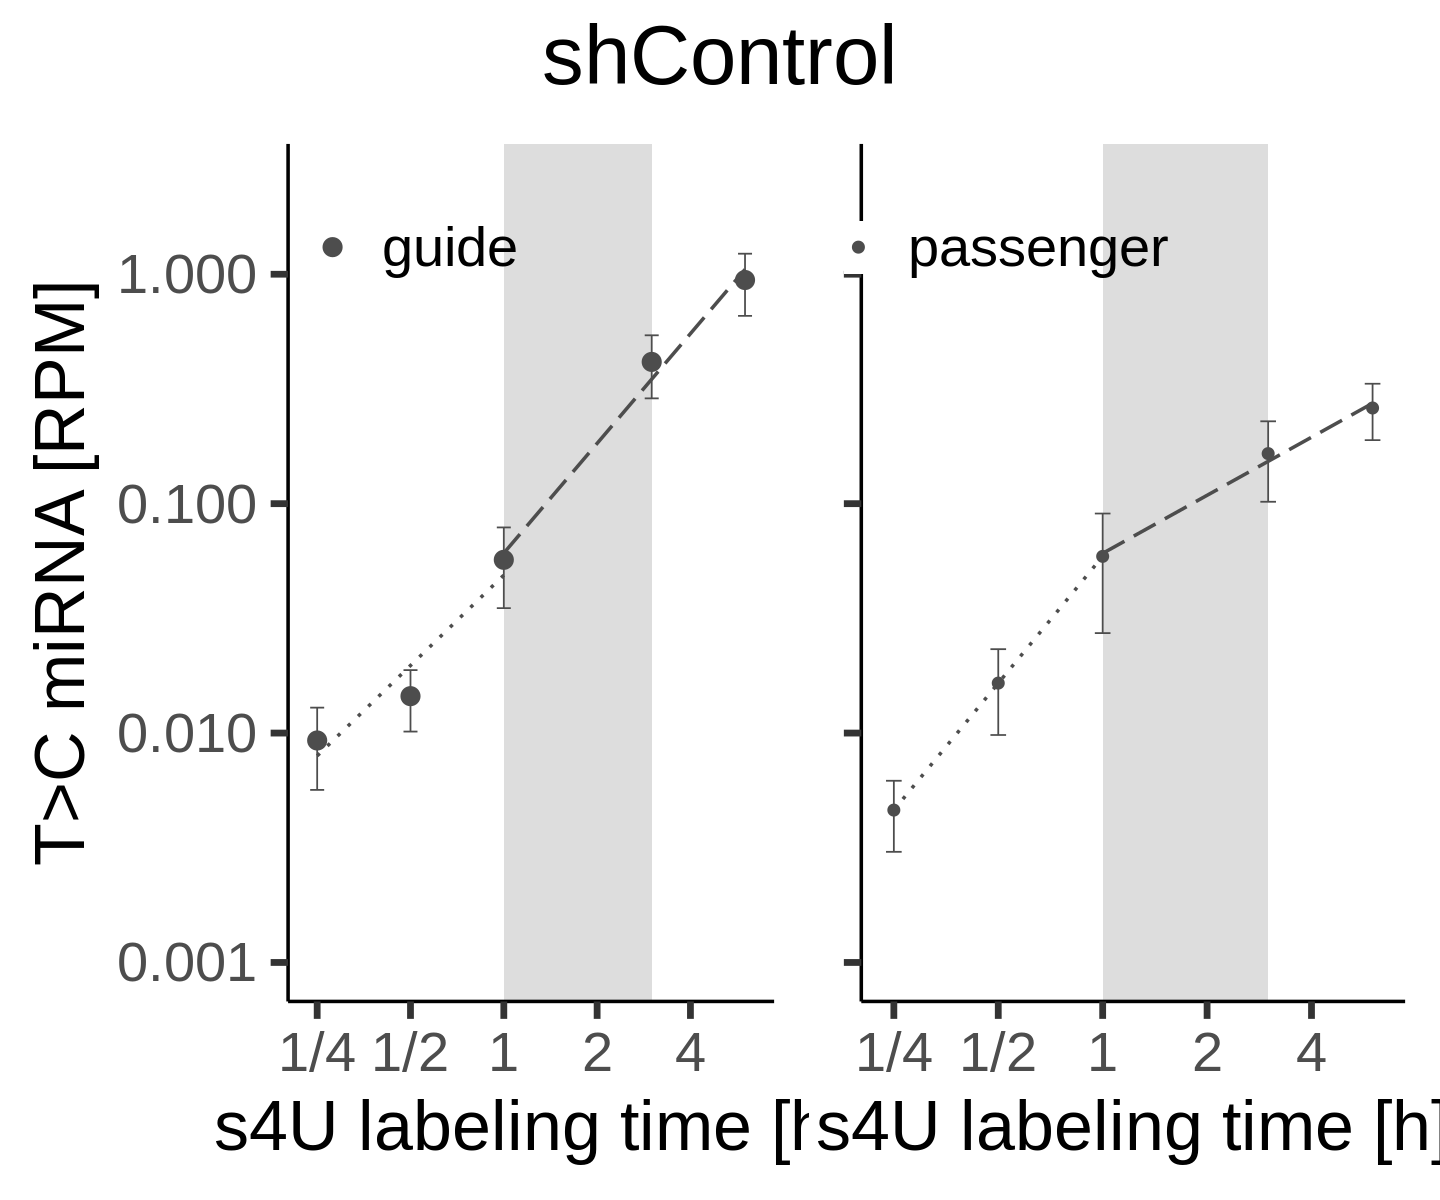

In [29]:
# plot next to each other


gfp.mature <- summarySE(fits.gfp.mature, measurevar="avg.tc.ppm", groupvars=c("time", "mir.type"))
gfp.star <- summarySE(fits.gfp.star, measurevar="avg.tc.ppm", groupvars=c("time", "mir.type"))

mg <- ggplot(data = gfp.mature, aes(x = time, y=avg.tc.ppm)) +
        theme_bw(base_size = 42) +
        #ggtitle("shControl") +
        #theme(plot.title = element_text(hjust = '0.5', size=50)) +
        theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
              panel.background = element_blank(), panel.border = element_blank()) +
        theme(axis.line = element_line(colour = "black", size = 1), 
              axis.title.x = element_text()) +
        theme(legend.position=c(0.27, 0.9), legend.title = element_blank(), 
              legend.background = element_rect(fill="transparent")) +
        scale_x_continuous(trans = 'log2', breaks =c(1/16, 1/8, 1/4,1/2, 1, 2, 4, 8, 16), 
                           label=c("1/16", "1/8", "1/4", "1/2", "1", "2", "4", "8", " 16"))+
        scale_y_continuous(trans = 'log10', limits=c(0.001, 2.5))+
        xlab("s4U labeling time [h]")+
        ylab("T>C miRNA [RPM]")+
        annotate("rect", xmin = 1, xmax = 3, ymin = 0, ymax = Inf, alpha = .2) +
        #geom_line(aes(linetype=mir.type), size=1.2, color=col_shgfp)+
        #scale_linetype_manual(values=c("solid", "dotted"))+
        geom_point(aes(size=mir.type), color=col_shgfp) +
        scale_size_manual(values=c(5)) +
        geom_errorbar(width=.15, aes(ymin=avg.tc.ppm-se, ymax=avg.tc.ppm+se), color=col_shgfp)  +
        geom_smooth(se=FALSE, method="lm", data=gfp.mature[gfp.mature$time <=1,], lty=3, color=col_shgfp)+
        geom_smooth(se=FALSE, method="lm", data=gfp.mature[gfp.mature$time >=1 & gfp.mature$time <= limit,], lty=5, color=col_shgfp) 

sg <- ggplot(data = gfp.star, aes(x = time, y=avg.tc.ppm)) +
        theme_bw(base_size = 42) +
        #ggtitle("shControl") +
        #theme(plot.title = element_text(hjust = '0.5', size=50)) +
        theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
              panel.background = element_blank(), panel.border = element_blank()) +
        theme(axis.line = element_line(colour = "black", size = 1), 
              axis.title.x = element_text(), axis.title.y = element_blank(), axis.text.y = element_blank()) +
        theme(legend.position=c(0.27, 0.9), legend.title = element_blank(), 
              legend.background = element_rect(fill="transparent")) +
        scale_x_continuous(trans = 'log2', breaks =c(1/16, 1/8, 1/4,1/2, 1, 2, 4, 8, 16), 
                           label=c("1/16", "1/8", "1/4", "1/2", "1", "2", "4", "8", " 16"))+
        scale_y_continuous(trans = 'log10', limits=c(0.001, 2.5))+
        xlab("s4U labeling time [h]")+
        annotate("rect", xmin = 1, xmax = 3, ymin = 0, ymax = Inf, alpha = .2) +
        #geom_line(aes(linetype=mir.type), size=1.2, color=col_shgfp)+
        #scale_linetype_manual(values=c("solid", "dotted"))+
        geom_point(aes(size=mir.type), color=col_shgfp) +
        scale_size_manual(values=c(3)) +
        geom_errorbar(width=.15, aes(ymin=avg.tc.ppm-se, ymax=avg.tc.ppm+se), color=col_shgfp)  +
        geom_smooth(se=FALSE, method="lm", data=gfp.star[gfp.star$time <=1,], lty=3, color=col_shgfp)+
        geom_smooth(se=FALSE, method="lm", data=gfp.star[gfp.star$time >=1& gfp.star$time <= limit,], lty=5, color=col_shgfp)
        #geom_abline(slope = lm.gfp.accu.mature$coefficients[2], intercept = lm.gfp.accu.mature$coefficients[1], color="red")

options(repr.plot.width=12, repr.plot.height=10)
plot_row <- plot_grid(mg,sg, ncol=2, rel_widths = c(1,0.78))

# now add the title
title <- ggdraw() + 
  draw_label("shControl", fontface = NULL, x = 0.5, hjust = 0.5, size=50) +
  theme(
    # add margin on the left of the drawing canvas,
    # so title is aligned with left edge of first plot
    plot.margin = margin(0, 0, 0, 0))

plot_grid(
  title, plot_row, ncol = 1,
  # rel_heights values control vertical title margins
  rel_heights = c(0.1, 1))


#options(repr.plot.width=15, repr.plot.height=10)
#plot_grid(mg,sg, ncol=2)


Warning message:
“Transformation introduced infinite values in continuous y-axis”
`geom_smooth()` using formula 'y ~ x'

`geom_smooth()` using formula 'y ~ x'

Warning message:
“Transformation introduced infinite values in continuous y-axis”
`geom_smooth()` using formula 'y ~ x'

`geom_smooth()` using formula 'y ~ x'



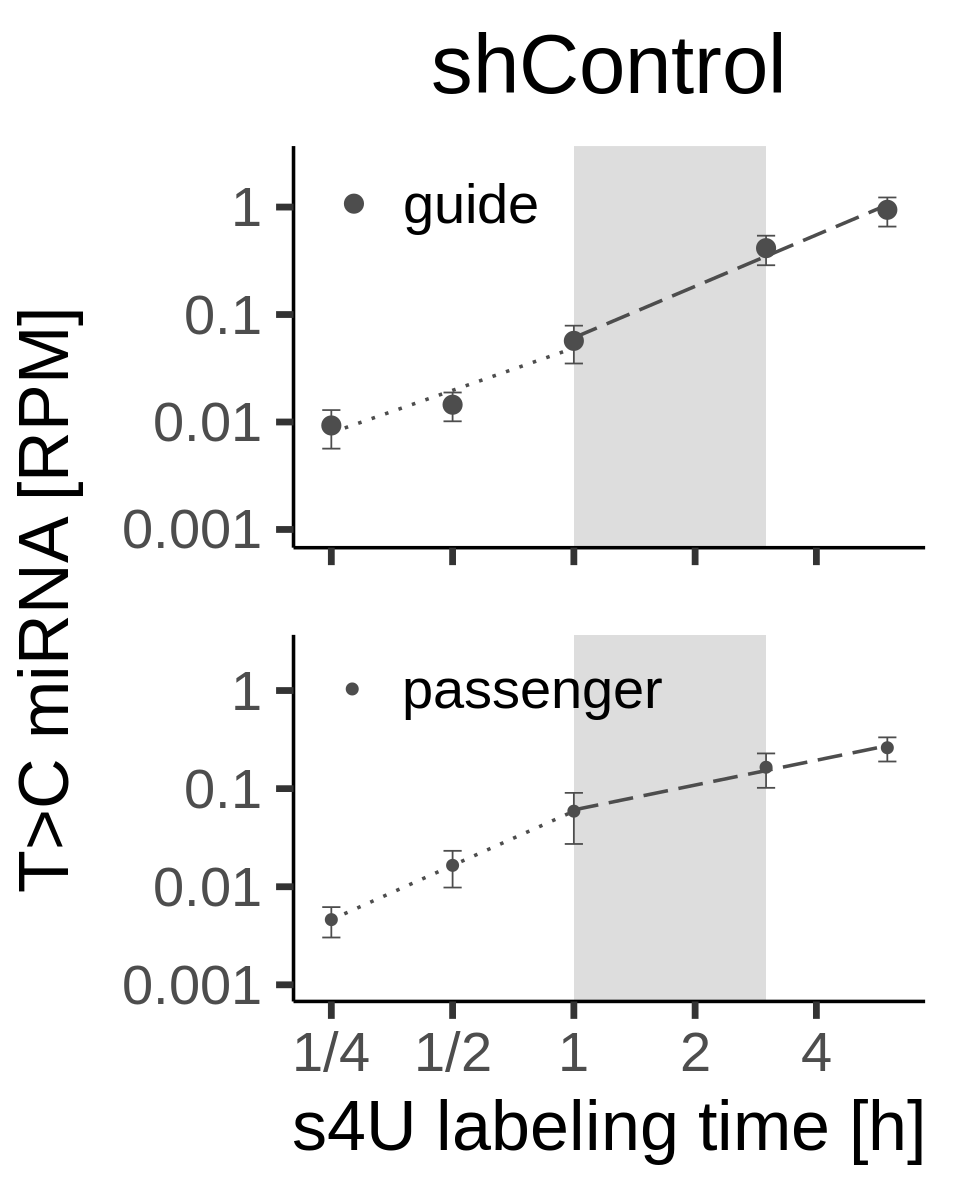

In [35]:
# plot on top of each other


gfp.mature <- summarySE(fits.gfp.mature, measurevar="avg.tc.ppm", groupvars=c("time", "mir.type"))
gfp.star <- summarySE(fits.gfp.star, measurevar="avg.tc.ppm", groupvars=c("time", "mir.type"))

mg <- ggplot(data = gfp.mature, aes(x = time, y=avg.tc.ppm)) +
        theme_bw(base_size = 42) +
        ggtitle("shControl") +
        theme(plot.title = element_text(hjust = '0.5', size=50)) +
        theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
              panel.background = element_blank(), panel.border = element_blank()) +
        theme(axis.line = element_line(colour = "black", size = 1), 
              axis.text.x = element_blank(), axis.title.x = element_blank(), axis.title.y = element_blank()) +
        theme(legend.position=c(0.233, 0.9), legend.title = element_blank(), 
              legend.background = element_rect(fill="transparent")) +
        scale_x_continuous(trans = 'log2', breaks =c(1/16, 1/8, 1/4,1/2, 1, 2, 4, 8, 16), 
                           label=c("1/16", "1/8", "1/4", "1/2", "1", "2", "4", "8", " 16"))+
        scale_y_continuous(trans = 'log10', limits=c(0.001, 2.5), breaks=c(0.001, 0.01, 0.1, 1), labels=c("0.001", "0.01", "0.1", "1"))+
        xlab("s4U labeling time [h]")+
        #ylab("T>C miRNA [RPM]")+
        annotate("rect", xmin = 1, xmax = 3, ymin = 0, ymax = Inf, alpha = .2) +
        #geom_line(aes(linetype=mir.type), size=1.2, color=col_shgfp)+
        #scale_linetype_manual(values=c("solid", "dotted"))+
        geom_point(aes(size=mir.type), color=col_shgfp) +
        scale_size_manual(values=c(5)) +
        geom_errorbar(width=.15, aes(ymin=avg.tc.ppm-se, ymax=avg.tc.ppm+se), color=col_shgfp)  +
        geom_smooth(se=FALSE, method="lm", data=gfp.mature[gfp.mature$time <=1,], lty=3, color=col_shgfp)+
        geom_smooth(se=FALSE, method="lm", data=gfp.mature[gfp.mature$time >=1 & gfp.mature$time <= limit,], lty=5, color=col_shgfp) 

sg <- ggplot(data = gfp.star, aes(x = time, y=avg.tc.ppm)) +
        theme_bw(base_size = 42) +
        #ggtitle("shControl") +
        #theme(plot.title = element_text(hjust = '0.5', size=50)) +
        theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
              panel.background = element_blank(), panel.border = element_blank()) +
        theme(axis.line = element_line(colour = "black", size = 1), 
              axis.title.x = element_text(), axis.title.y = element_blank(), axis.text.y = element_text()) +
        theme(legend.position=c(0.33, 0.9), legend.title = element_blank(), 
              legend.background = element_rect(fill="transparent")) +
        scale_x_continuous(trans = 'log2', breaks =c(1/16, 1/8, 1/4,1/2, 1, 2, 4, 8, 16), 
                           label=c("1/16", "1/8", "1/4", "1/2", "1", "2", "4", "8", " 16"))+
        scale_y_continuous(trans = 'log10', limits=c(0.001, 2.5), breaks=c(0.001, 0.01, 0.1, 1), labels=c("0.001", "0.01", "0.1", "1"))+
        xlab("s4U labeling time [h]")+
        annotate("rect", xmin = 1, xmax = 3, ymin = 0, ymax = Inf, alpha = .2) +
        #geom_line(aes(linetype=mir.type), size=1.2, color=col_shgfp)+
        #scale_linetype_manual(values=c("solid", "dotted"))+
        geom_point(aes(size=mir.type), color=col_shgfp) +
        scale_size_manual(values=c(3)) +
        geom_errorbar(width=.15, aes(ymin=avg.tc.ppm-se, ymax=avg.tc.ppm+se), color=col_shgfp)  +
        geom_smooth(se=FALSE, method="lm", data=gfp.star[gfp.star$time <=1,], lty=3, color=col_shgfp)+
        geom_smooth(se=FALSE, method="lm", data=gfp.star[gfp.star$time >=1& gfp.star$time <= limit,], lty=5, color=col_shgfp)
        #geom_abline(slope = lm.gfp.accu.mature$coefficients[2], intercept = lm.gfp.accu.mature$coefficients[1], color="red")

options(repr.plot.width=8, repr.plot.height=10)
plot_row <- plot_grid(mg,sg, nrow=2, rel_heights = c(1, 1))

# now add the title
title <- ggdraw() + 
  draw_label("T>C miRNA [RPM]", fontface = NULL, angle=90, x = 0.5, hjust = 0.5, size=42) +
  theme(
    # add margin on the left of the drawing canvas,
    # so title is aligned with left edge of first plot
    plot.margin = margin(0, 0, 0, 0))

fin.plot <- plot_grid(
  title, plot_row, ncol = 2,
  rel_widths = c(0.1, 1))

fin.plot
#options(repr.plot.width=15, repr.plot.height=10)
#plot_grid(mg,sg, ncol=2)


In [ ]:
# Figures don't appear in paper

Warning message:
“Transformation introduced infinite values in continuous y-axis”
`geom_smooth()` using formula 'y ~ x'

`geom_smooth()` using formula 'y ~ x'

Warning message:
“Transformation introduced infinite values in continuous y-axis”
`geom_smooth()` using formula 'y ~ x'

`geom_smooth()` using formula 'y ~ x'



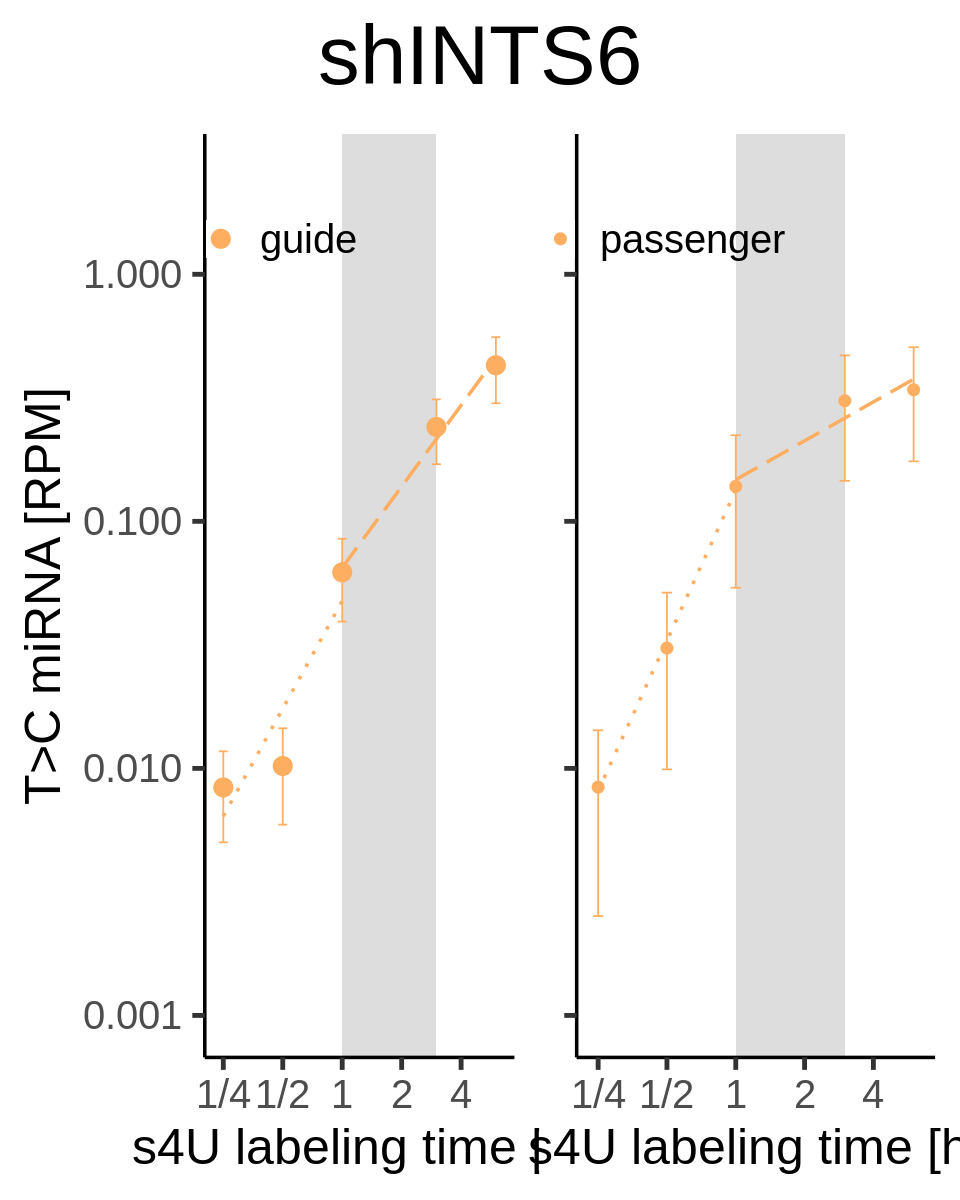

In [32]:
ints.mature <- summarySE(fits.6.mature, measurevar="avg.tc.ppm", groupvars=c("time", "mir.type"))
ints.star <- summarySE(fits.6.star, measurevar="avg.tc.ppm", groupvars=c("time", "mir.type"))

m11 <- ggplot(data = ints.mature, aes(x = time, y=avg.tc.ppm)) +
        theme_bw(base_size = 30) +
        #ggtitle("shINTS6") +
        #theme(plot.title = element_text(hjust = '0.5', size=50)) +
        theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
              panel.background = element_blank(), panel.border = element_blank()) +
        theme(axis.line = element_line(colour = "black", size = 1), 
              axis.title.x = element_text()) +
        theme(legend.position=c(0.25, 0.9), legend.title = element_blank(), 
              legend.background = element_rect(fill="transparent")) +
        scale_x_continuous(trans = 'log2', breaks =c(1/16, 1/8, 1/4,1/2, 1, 2, 4, 8, 16), 
                           label=c("1/16", "1/8", "1/4", "1/2", "1", "2", "4", "8", " 16"))+
        scale_y_continuous(trans = 'log10', limits=c(0.001, 2.5))+
        xlab("s4U labeling time [h]")+
        ylab("T>C miRNA [RPM]")+
        annotate("rect", xmin = 1, xmax = 3, ymin = 0, ymax = Inf, alpha = .2) +
        #geom_line(aes(linetype=mir.type), size=1.2, color=col_shgfp)+
        #scale_linetype_manual(values=c("solid", "dotted"))+
        geom_point(aes(size=mir.type), color=col_sh6) +
        scale_size_manual(values=c(5)) +
        geom_errorbar(width=.15, aes(ymin=avg.tc.ppm-se, ymax=avg.tc.ppm+se), color=col_sh6)  +
        geom_smooth(se=FALSE, method="lm", data=ints.mature[ints.mature$time <=1,], lty=3, color=col_sh6)+
        geom_smooth(se=FALSE, method="lm", data=ints.mature[ints.mature$time >=1 & ints.mature$time <=limit ,], lty=5, color=col_sh6)

s11 <- ggplot(data = ints.star, aes(x = time, y=avg.tc.ppm)) +
        theme_bw(base_size = 30) +
        #ggtitle("shINTS6") +
        #theme(plot.title = element_text(hjust = '0.5', size=50)) +
        theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
              panel.background = element_blank(), panel.border = element_blank()) +
        theme(axis.line = element_line(colour = "black", size = 1), 
              axis.title.x = element_text(), axis.title.y = element_blank(), axis.text.y = element_blank()) +
        theme(legend.position=c(0.25, 0.9), legend.title = element_blank(), 
              legend.background = element_rect(fill="transparent")) +
        scale_x_continuous(trans = 'log2', breaks =c(1/16, 1/8, 1/4,1/2, 1, 2, 4, 8, 16), 
                           label=c("1/16", "1/8", "1/4", "1/2", "1", "2", "4", "8", " 16"))+
        scale_y_continuous(trans = 'log10', limits=c(0.001, 2.5))+
        xlab("s4U labeling time [h]")+
        #ylab("T>C miRNA [RPM]")+
        annotate("rect", xmin = 1, xmax = 3, ymin = 0, ymax = Inf, alpha = .2) +
        #geom_line(aes(linetype=mir.type), size=1.2, color=col_shgfp)+
        #scale_linetype_manual(values=c("solid", "dotted"))+
        geom_point(aes(size=mir.type), color=col_sh6) +
        scale_size_manual(values=c(3)) +
        geom_errorbar(width=.15, aes(ymin=avg.tc.ppm-se, ymax=avg.tc.ppm+se), color=col_sh6)  +
        geom_smooth(se=FALSE, method="lm", data=ints.star[ints.star$time <=1,], lty=3, color=col_sh6)+
        geom_smooth(se=FALSE, method="lm", data=ints.star[ints.star$time >=1 & ints.mature$time <=limit,], lty=5, color=col_sh6)
       # geom_abline(slope = lm.gfp.accu.mature$coefficients[2], intercept = lm.gfp.accu.mature$coefficients[1], color="red")

plot_row <- plot_grid(m11,s11, ncol=2, rel_widths = c(1,0.78))

# now add the title
title <- ggdraw() + 
  draw_label("shINTS6", fontface = NULL, x = 0.5, hjust = 0.5, size=50) +
  theme(
    # add margin on the left of the drawing canvas,
    # so title is aligned with left edge of first plot
    plot.margin = margin(0, 0, 0, 0))

plot_grid(
  title, plot_row, ncol = 1,
  # rel_heights values control vertical title margins
  rel_heights = c(0.1, 1))


#options(repr.plot.width=20, repr.plot.height=10)
#plot_grid(m11,s11, ncol=2)

Warning message:
“Transformation introduced infinite values in continuous y-axis”
`geom_smooth()` using formula 'y ~ x'

`geom_smooth()` using formula 'y ~ x'

Warning message:
“Transformation introduced infinite values in continuous y-axis”
`geom_smooth()` using formula 'y ~ x'

`geom_smooth()` using formula 'y ~ x'



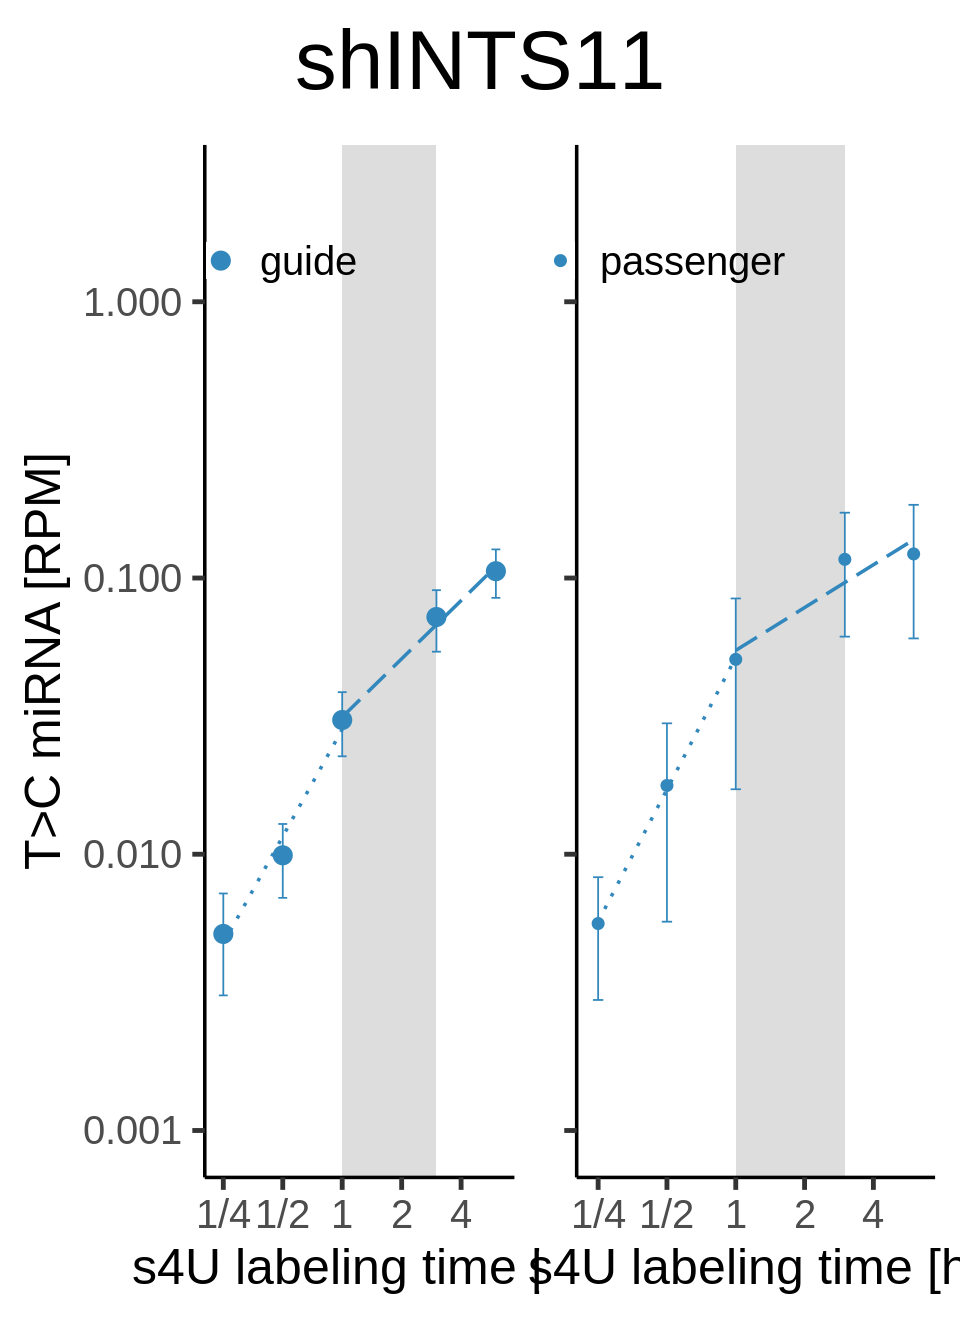

In [76]:
ints.mature <- summarySE(fits.11.mature, measurevar="avg.tc.ppm", groupvars=c("time", "mir.type"))
ints.star <- summarySE(fits.11.star, measurevar="avg.tc.ppm", groupvars=c("time", "mir.type"))

m11 <- ggplot(data = ints.mature, aes(x = time, y=avg.tc.ppm)) +
        theme_bw(base_size = 30) +
        #ggtitle("shINTS6") +
        #theme(plot.title = element_text(hjust = '0.5', size=50)) +
        theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
              panel.background = element_blank(), panel.border = element_blank()) +
        theme(axis.line = element_line(colour = "black", size = 1), 
              axis.title.x = element_text()) +
        theme(legend.position=c(0.25, 0.9), legend.title = element_blank(), 
              legend.background = element_rect(fill="transparent")) +
        scale_x_continuous(trans = 'log2', breaks =c(1/16, 1/8, 1/4,1/2, 1, 2, 4, 8, 16), 
                           label=c("1/16", "1/8", "1/4", "1/2", "1", "2", "4", "8", " 16"))+
        scale_y_continuous(trans = 'log10', limits=c(0.001, 2.5))+
        xlab("s4U labeling time [h]")+
        ylab("T>C miRNA [RPM]")+
        annotate("rect", xmin = 1, xmax = 3, ymin = 0, ymax = Inf, alpha = .2) +
        #geom_line(aes(linetype=mir.type), size=1.2, color=col_shgfp)+
        #scale_linetype_manual(values=c("solid", "dotted"))+
        geom_point(aes(size=mir.type), color=col_sh11) +
        scale_size_manual(values=c(5)) +
        geom_errorbar(width=.15, aes(ymin=avg.tc.ppm-se, ymax=avg.tc.ppm+se), color=col_sh11)  +
        geom_smooth(se=FALSE, method="lm", data=ints.mature[ints.mature$time <=1,], lty=3, color=col_sh11)+
        geom_smooth(se=FALSE, method="lm", data=ints.mature[ints.mature$time >=1 & ints.mature$time <=limit ,], lty=5, color=col_sh11)

s11 <- ggplot(data = ints.star, aes(x = time, y=avg.tc.ppm)) +
        theme_bw(base_size = 30) +
        #ggtitle("shINTS6") +
        #theme(plot.title = element_text(hjust = '0.5', size=50)) +
        theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
              panel.background = element_blank(), panel.border = element_blank()) +
        theme(axis.line = element_line(colour = "black", size = 1), 
              axis.title.x = element_text(), axis.title.y = element_blank(), axis.text.y = element_blank()) +
        theme(legend.position=c(0.25, 0.9), legend.title = element_blank(), 
              legend.background = element_rect(fill="transparent")) +
        scale_x_continuous(trans = 'log2', breaks =c(1/16, 1/8, 1/4,1/2, 1, 2, 4, 8, 16), 
                           label=c("1/16", "1/8", "1/4", "1/2", "1", "2", "4", "8", " 16"))+
        scale_y_continuous(trans = 'log10', limits=c(0.001, 2.5))+
        xlab("s4U labeling time [h]")+
        #ylab("T>C miRNA [RPM]")+
        annotate("rect", xmin = 1, xmax = 3, ymin = 0, ymax = Inf, alpha = .2) +
        #geom_line(aes(linetype=mir.type), size=1.2, color=col_shgfp)+
        #scale_linetype_manual(values=c("solid", "dotted"))+
        geom_point(aes(size=mir.type), color=col_sh11) +
        scale_size_manual(values=c(3)) +
        geom_errorbar(width=.15, aes(ymin=avg.tc.ppm-se, ymax=avg.tc.ppm+se), color=col_sh11)  +
        geom_smooth(se=FALSE, method="lm", data=ints.star[ints.star$time <=1,], lty=3, color=col_sh11)+
        geom_smooth(se=FALSE, method="lm", data=ints.star[ints.star$time >=1 & ints.mature$time <=limit,], lty=5, color=col_sh11)
       # geom_abline(slope = lm.gfp.accu.mature$coefficients[2], intercept = lm.gfp.accu.mature$coefficients[1], color="red")

plot_row <- plot_grid(m11,s11, ncol=2, rel_widths = c(1,0.78))

# now add the title
title <- ggdraw() + 
  draw_label("shINTS11", fontface = NULL, x = 0.5, hjust = 0.5, size=50) +
  theme(
    # add margin on the left of the drawing canvas,
    # so title is aligned with left edge of first plot
    plot.margin = margin(0, 0, 0, 0))

plot_grid(
  title, plot_row, ncol = 1,
  # rel_heights values control vertical title margins
  rel_heights = c(0.1, 1))


#options(repr.plot.width=20, repr.plot.height=10)
#plot_grid(m11,s11, ncol=2)

In [77]:
# plot as histogram

In [78]:
#summary(lm.gfp.bio.mature)
#summary(lm.gfp.bio.star)

#summary(lm.6.bio.mature)
#summary(lm.6.bio.star)

#summary(lm.11.bio.mature)
#summary(lm.11.bio.star)

#summary(lm.gfp.accu.mature)
#summary(lm.gfp.accu.star)

#summary(lm.6.accu.mature)
#summary(lm.6.accu.star)

#summary(lm.11.accu.mature)
summary(lm.11.accu.star)


Call:
lm(formula = avg.tc.ppm ~ time, data = fits.11.accu.star)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.13209 -0.09088 -0.06556 -0.04166  1.75639 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)
(Intercept)  0.05225    0.05670   0.921    0.359
time         0.01331    0.01448   0.919    0.361

Residual standard error: 0.2869 on 91 degrees of freedom
Multiple R-squared:  0.009196,	Adjusted R-squared:  -0.001692 
F-statistic: 0.8446 on 1 and 91 DF,  p-value: 0.3605


In [33]:
b <- as.data.frame(matrix(NA, ncol=3,nrow=6))
colnames(b) <- c("sample", "kbio", "SEM")
b$sample <- c("shC.mature", "shC.star","sh6.mature", "sh6.star", "sh11.mature", "sh11.star")
b$kbio <-as.numeric(c(0.066, 0.074, 0.076, 0.179, 0.035, 0.061))
b$SEM <- as.numeric(c(0.024, 0.034, 0.025, 0.093, 0.009, 0.038))
b


a <- as.data.frame(matrix(NA, ncol=3,nrow=6))
colnames(a) <- c("sample", "kaccu", "SEM")
a$sample <- c("shC.mature", "shC.star","sh6.mature", "sh6.star", "sh11.mature", "sh11.star")
a$kaccu <- as.numeric(c(0.177, 0.040, 0.071, 0.038, 0.015, 0.013))
a$SEM <- as.numeric(c(0.050, 0.016, 0.024, 0.040, 0.005, 0.014))
a


sample,kbio,SEM
<chr>,<dbl>,<dbl>
shC.mature,0.066,0.024
shC.star,0.074,0.034
sh6.mature,0.076,0.025
sh6.star,0.179,0.093
sh11.mature,0.035,0.009
sh11.star,0.061,0.038


sample,kaccu,SEM
<chr>,<dbl>,<dbl>
shC.mature,0.177,0.050
shC.star,0.040,0.016
sh6.mature,0.071,0.024
sh6.star,0.038,0.040
sh11.mature,0.015,0.005
sh11.star,0.013,0.014


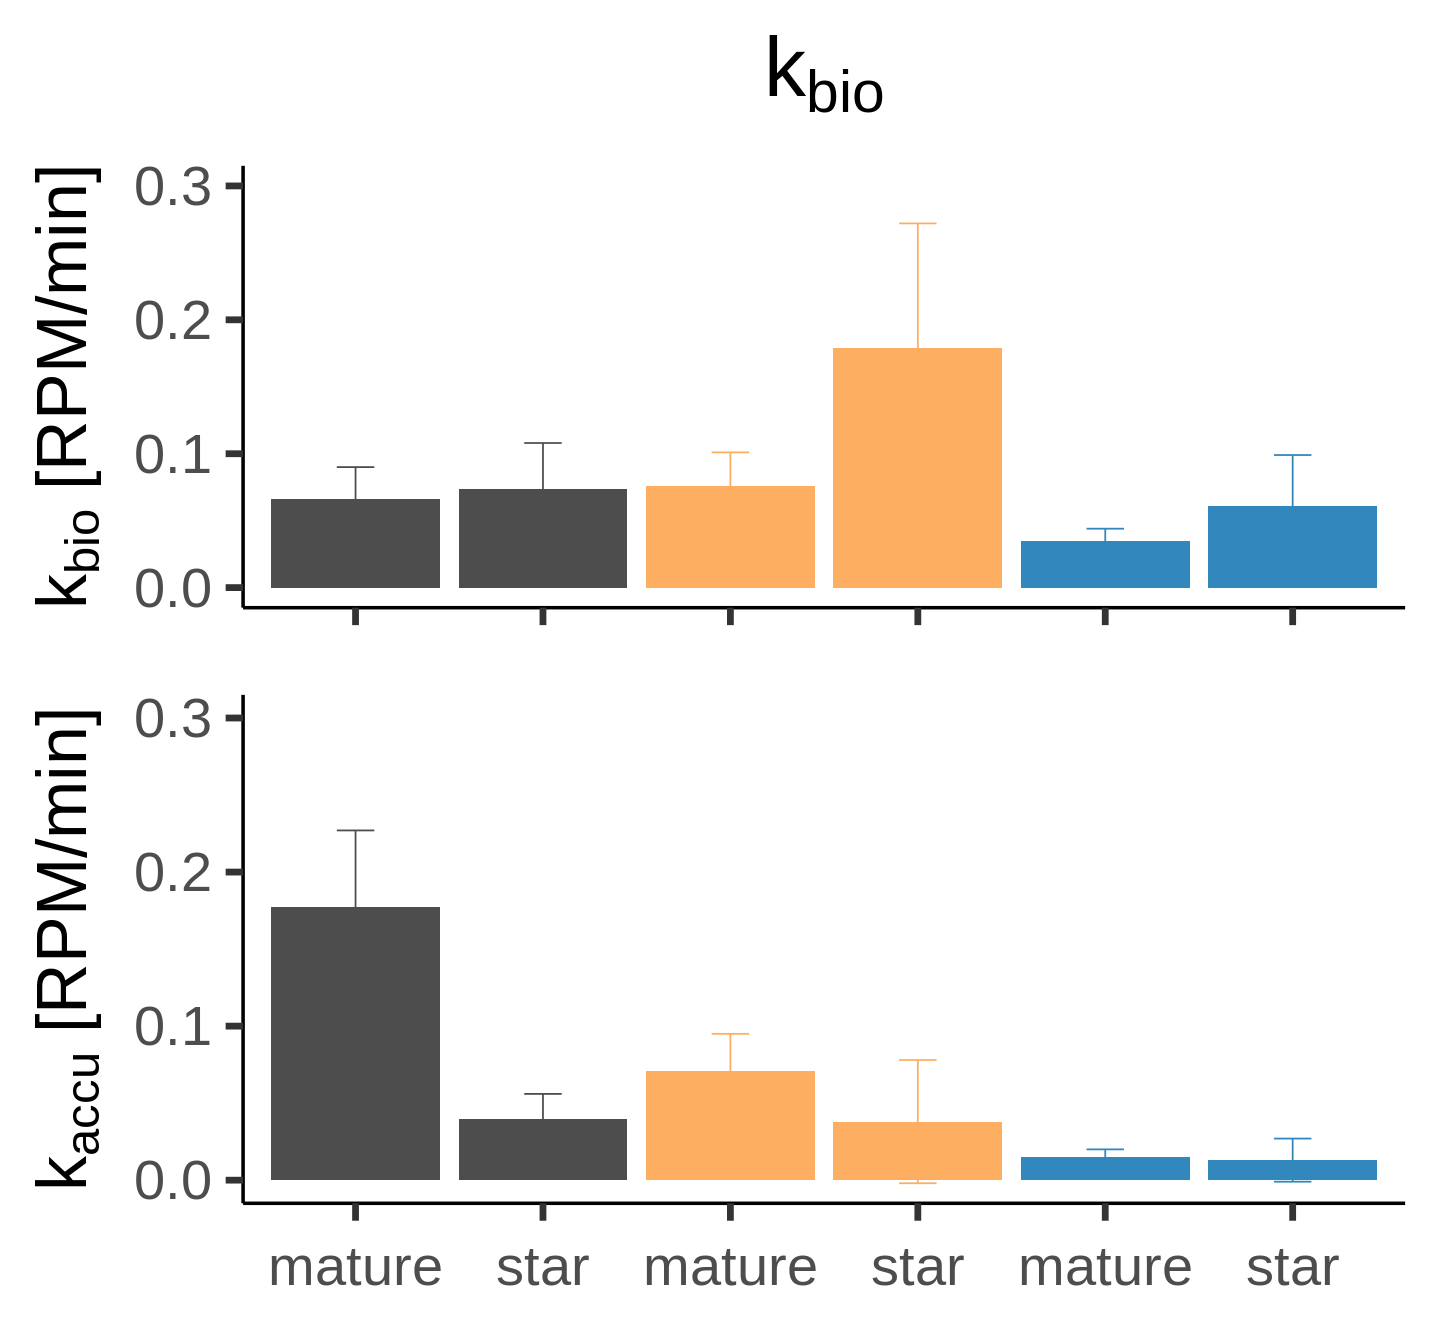

In [81]:
# figure stacked


bio <- ggplot(b, aes(x=sample, y=kbio)) + 
    theme_bw(base_size = 42) +
    ggtitle(expression(k[bio])) +
    theme(plot.title = element_text(hjust = '0.5')) +
    theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
              panel.background = element_blank(), panel.border = element_blank()) +
    theme(axis.line = element_line(colour = "black", size = 1), 
              axis.title.x = element_blank(), axis.text.x = element_blank()) +
     #scale_y_continuous(limits=c(0,0.07))+#trans = 'log2', breaks=c(0.004, 0.03, 0.25,2))+
    coord_cartesian(ylim=c(0, 0.3)) +
    ylab(expression('k'[bio]*' [RPM/min]'))  +
    #scale_x_discrete(limits=c("shC.mature", "sh6.mature", "shC.star", "sh6.star")) +
    scale_x_discrete(limits=c("shC.mature", "shC.star", "sh6.mature", "sh6.star", "sh11.mature", "sh11.star")) +
    geom_col(fill=c(col_shgfp, col_shgfp, col_sh6, col_sh6, col_sh11, col_sh11)) +
    geom_errorbar(aes(ymin=kbio-SEM, ymax=kbio+SEM), width=.2, col=c(col_shgfp,  col_shgfp, col_sh6,col_sh6, col_sh11,col_sh11))




accu <- ggplot(a, aes(x=sample, y=kaccu)) + 
    theme_bw(base_size = 42) +
    #ggtitle(expression(k[accu])) +
    #theme(plot.title = element_text(hjust = '0.5')) +
    theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
              panel.background = element_blank(), panel.border = element_blank()) +
    theme(axis.line = element_line(colour = "black", size = 1), 
              axis.title.x = element_blank(), axis.text.x = element_text(angle = 0, vjust = 0, hjust=0.5)) +
    #scale_y_continuous(limits=c(0,0.07))+#trans = 'log2', breaks=c(0.004, 0.03, 0.25,2))+
    coord_cartesian(ylim=c(0, 0.3)) +
    ylab(expression('k'[accu]*' [RPM/min]'))  +
    #scale_x_discrete(limits=c("shC.mature", "sh6.mature", "shC.star", "sh6.star")) +
    scale_x_discrete(limits=c("shC.mature", "shC.star", "sh6.mature", "sh6.star", "sh11.mature", "sh11.star"),
                    labels=c("mature", "star", "mature", "star", "mature", "star")) +
    geom_col(fill=c(col_shgfp, col_shgfp, col_sh6, col_sh6, col_sh11, col_sh11)) +
    geom_errorbar(aes(ymin=kaccu-SEM, ymax=kaccu+SEM), width=.2, col=c(col_shgfp,  col_shgfp, col_sh6,col_sh6, col_sh11,col_sh11))

options(repr.plot.width=12, repr.plot.height=11)
plot_grid(bio, accu, nrow=2, rel_heights=c(1,1))

In [ ]:
# Figure 3h

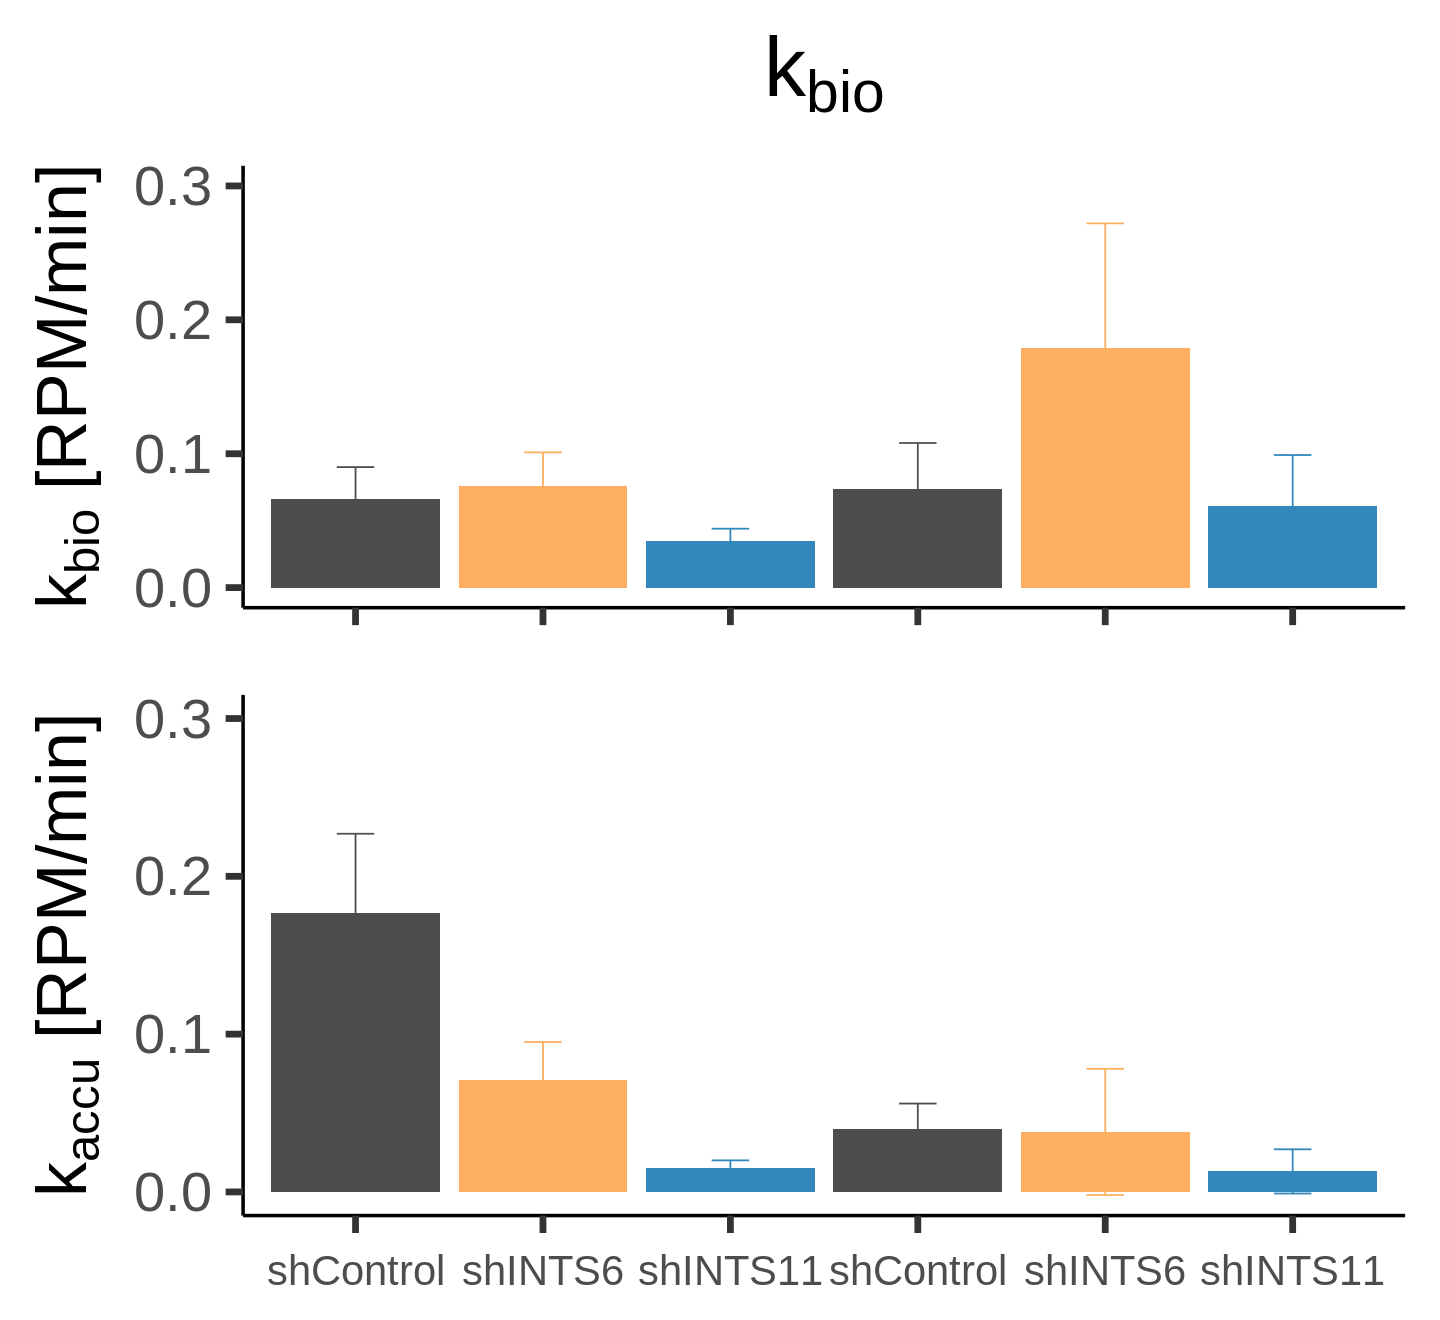

In [89]:
# figure stacked REORDER


bio <- ggplot(b, aes(x=sample, y=kbio)) + 
    theme_bw(base_size = 42) +
    ggtitle(expression(k[bio])) +
    theme(plot.title = element_text(hjust = '0.5')) +
    theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
              panel.background = element_blank(), panel.border = element_blank()) +
    theme(axis.line = element_line(colour = "black", size = 1), 
              axis.title.x = element_blank(), axis.text.x = element_blank()) +
    #scale_y_continuous(trans = 'log2', breaks=c(0.004, 0.03, 0.25,2))+
    coord_cartesian(ylim=c(0, 0.3)) +
    ylab(expression('k'[bio]*' [RPM/min]'))  +
    scale_x_discrete(limits=c("shC.mature", "sh6.mature","sh11.mature", "shC.star", "sh6.star", "sh11.star")) +
    #scale_x_discrete(limits=c("shC.mature", "shC.star", "sh6.mature", "sh6.star", "sh11.mature", "sh11.star")) +
    geom_col(fill=c(col_shgfp, col_shgfp, col_sh6, col_sh6, col_sh11, col_sh11)) +
    geom_errorbar(aes(ymin=kbio-SEM, ymax=kbio+SEM), width=.2, col=c(col_shgfp,  col_shgfp, col_sh6,col_sh6, col_sh11,col_sh11))




accu <- ggplot(a, aes(x=sample, y=kaccu)) + 
    theme_bw(base_size = 42) +
    #ggtitle(expression(k[accu])) +
    #theme(plot.title = element_text(hjust = '0.5')) +
    theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
              panel.background = element_blank(), panel.border = element_blank()) +
    theme(axis.line = element_line(colour = "black", size = 1), 
              axis.title.x = element_blank(), axis.text.x = element_text(angle = 0, vjust = 0, hjust=0.5, size=25)) +
    #scale_y_continuous(limits=c(0,0.07))+#trans = 'log2', breaks=c(0.004, 0.03, 0.25,2))+
    coord_cartesian(ylim=c(0, 0.3)) +
    ylab(expression('k'[accu]*' [RPM/min]'))  +
    scale_x_discrete(limits=c("shC.mature", "sh6.mature","sh11.mature", "shC.star", "sh6.star", "sh11.star"),
                    labels=c("shControl", "shINTS6", "shINTS11","shControl", "shINTS6", "shINTS11")) +
    #scale_x_discrete(limits=c("shC.mature", "shC.star", "sh6.mature", "sh6.star", "sh11.mature", "sh11.star"),
    #                labels=c("mature", "star", "mature", "star", "mature", "star")) +
    geom_col(fill=c(col_shgfp, col_shgfp, col_sh6, col_sh6, col_sh11, col_sh11)) +
    geom_errorbar(aes(ymin=kaccu-SEM, ymax=kaccu+SEM), width=.2, col=c(col_shgfp,  col_shgfp, col_sh6,col_sh6, col_sh11,col_sh11))

options(repr.plot.width=12, repr.plot.height=11)
plot_grid(bio, accu, nrow=2, rel_heights=c(1,1))

# k(bio) and k(accu) per miRNA and plot boxplot

In [37]:
head(fits.gfp.bio.mature)

box.gfp.bio.mature <- fits.gfp.bio.mature %>%
    group_by(arm.name) %>%
    do(lm.fit = lm(avg.tc.ppm ~ time, data = .)) %>%
    tidy(lm.fit) %>%
    filter(term=="time") %>%    
    ungroup() %>%
    select(arm.name, k.bio = estimate) %>%
    mutate(sample = "shCm")#"shControl_mature")

head(box.gfp.bio.mature)

box.gfp.bio.star <- fits.gfp.bio.star %>%
    group_by(arm.name) %>%
    do(lm.fit = lm(avg.tc.ppm ~ time, data = .)) %>%
    tidy(lm.fit) %>%
    filter(term=="time") %>%
    ungroup() %>%
    select(arm.name, k.bio = estimate) %>%
    mutate(sample = "shCs")#= "shControl_star")

box.6.bio.mature <- fits.6.bio.mature %>%
    group_by(arm.name) %>%
    do(lm.fit = lm(avg.tc.ppm ~ time, data = .)) %>%
    tidy(lm.fit) %>%
    filter(term=="time") %>%
    ungroup() %>%
    select(arm.name, k.bio = estimate) %>%
    mutate(sample = "sh6m")#= "shINTS6_mature")

box.6.bio.star <- fits.6.bio.star %>%
    group_by(arm.name) %>%
    do(lm.fit = lm(avg.tc.ppm ~ time, data = .)) %>%
    tidy(lm.fit) %>%
    filter(term=="time") %>%
    ungroup() %>%
    select(arm.name, k.bio = estimate) %>%
    mutate(sample = "sh6s")#= "shINTS6_star")

box.11.bio.mature <- fits.11.bio.mature %>%
    group_by(arm.name) %>%
    do(lm.fit = lm(avg.tc.ppm ~ time, data = .)) %>%
    tidy(lm.fit) %>%
    filter(term=="time") %>%
    ungroup() %>%
    select(arm.name, k.bio = estimate) %>%
    mutate(sample = "sh11m")#= "shINTS6_mature")

box.11.bio.star <- fits.11.bio.star %>%
    group_by(arm.name) %>%
    do(lm.fit = lm(avg.tc.ppm ~ time, data = .)) %>%
    tidy(lm.fit) %>%
    filter(term=="time") %>%
    ungroup() %>%
    select(arm.name, k.bio = estimate) %>%
    mutate(sample = "sh11s")#= "shINTS6_star")


box.bio <- box.gfp.bio.mature %>%
    bind_rows(box.gfp.bio.star, box.6.bio.mature, box.6.bio.star, box.11.bio.mature, box.11.bio.star)

arm.name,time,mir.type,avg.tc.ppm
<chr>,<dbl>,<chr>,<dbl>
miR-25-3p,0.25,guide,0.10578792
miR-25-3p,0.50,guide,0.07345855
miR-25-3p,1.00,guide,0.23020816
let-7d-5p,0.25,guide,0.00000000
let-7d-5p,0.50,guide,0.06343105
let-7d-5p,1.00,guide,0.14667281


arm.name,k.bio,sample
<chr>,<dbl>,<chr>
let-7d-5p,0.191409426,shCm
let-7i-5p,0.039080447,shCm
miR-106b-3p,0.095798893,shCm
miR-130b-3p,-0.002710209,shCm
miR-140-3p,0.000000000,shCm
miR-151a-3p,0.065043915,shCm


In [38]:
nrow(box.gfp.bio.mature[box.gfp.bio.mature$k.bio>0,])
nrow(box.gfp.bio.star[box.gfp.bio.star$k.bio>0,])
nrow(box.6.bio.mature[box.6.bio.mature$k.bio>0,])
nrow(box.6.bio.star[box.6.bio.star$k.bio>0,])
nrow(box.11.bio.mature[box.11.bio.mature$k.bio>0,])
nrow(box.11.bio.star[box.11.bio.star$k.bio>0,])

[1] 20

[1] 18

[1] 21

[1] 23

[1] 21

[1] 14

In [39]:
head(fits.gfp.accu.mature)

box.gfp.accu.mature <- fits.gfp.accu.mature %>%
    group_by(arm.name) %>%
    do(lm.fit = lm(avg.tc.ppm ~ time, data = .)) %>%
    tidy(lm.fit) %>%
    filter(term=="time") %>%
    ungroup() %>%
    select(arm.name, k.accu = estimate) %>%
    mutate(sample = "shCm")#= "shControl_mature")

head(box.gfp.accu.mature)

box.gfp.accu.star <- fits.gfp.accu.star %>%
    group_by(arm.name) %>%
    do(lm.fit = lm(avg.tc.ppm ~ time, data = .)) %>%
    tidy(lm.fit) %>%
    filter(term=="time") %>%
    ungroup() %>%
    select(arm.name, k.accu = estimate) %>%
    mutate(sample = "shCs")#= "shControl_star")

box.6.accu.mature <- fits.6.accu.mature %>%
    group_by(arm.name) %>%
    do(lm.fit = lm(avg.tc.ppm ~ time, data = .)) %>%
    tidy(lm.fit) %>%
    filter(term=="time") %>%
    ungroup() %>%
    select(arm.name, k.accu = estimate) %>%
    mutate(sample = "sh6m")#= "shINTS6_mature")

box.6.accu.star <- fits.6.accu.star %>%
    group_by(arm.name) %>%
    do(lm.fit = lm(avg.tc.ppm ~ time, data = .)) %>%
    tidy(lm.fit) %>%
    filter(term=="time") %>%
    ungroup() %>%
    select(arm.name, k.accu = estimate) %>%
    mutate(sample = "sh6s")#= "shINTS6_star")

box.11.accu.mature <- fits.11.accu.mature %>%
    group_by(arm.name) %>%
    do(lm.fit = lm(avg.tc.ppm ~ time, data = .)) %>%
    tidy(lm.fit) %>%
    filter(term=="time") %>%
    ungroup() %>%
    select(arm.name, k.accu = estimate) %>%
    mutate(sample = "sh11m")#= "shINTS6_mature")

box.11.accu.star <- fits.11.accu.star %>%
    group_by(arm.name) %>%
    do(lm.fit = lm(avg.tc.ppm ~ time, data = .)) %>%
    tidy(lm.fit) %>%
    filter(term=="time") %>%
    ungroup() %>%
    select(arm.name, k.accu = estimate) %>%
    mutate(sample = "sh11s")#= "shINTS6_star")

box.accu <- box.gfp.accu.mature %>%
    bind_rows(box.gfp.accu.star, box.6.accu.mature, box.6.accu.star, box.11.accu.mature, box.11.accu.star)

arm.name,time,mir.type,avg.tc.ppm
<chr>,<dbl>,<chr>,<dbl>
miR-25-3p,1,guide,0.2302082
miR-25-3p,3,guide,1.4803791
miR-25-3p,6,guide,3.4069497
let-7d-5p,1,guide,0.1466728
let-7d-5p,3,guide,1.2129480
let-7d-5p,6,guide,3.4588300


arm.name,k.accu,sample
<chr>,<dbl>,<chr>
let-7d-5p,0.66923638,shCm
let-7i-5p,0.46457142,shCm
miR-106b-3p,0.07099514,shCm
miR-130b-3p,0.03243516,shCm
miR-140-3p,0.05981065,shCm
miR-151a-3p,0.14692436,shCm


In [40]:
nrow(box.gfp.accu.mature[box.gfp.accu.mature$k.accu>0,])
nrow(box.gfp.accu.star[box.gfp.accu.star$k.accu>0,])
nrow(box.6.accu.mature[box.6.accu.mature$k.accu>0,])
nrow(box.6.accu.star[box.6.accu.star$k.accu>0,])
nrow(box.11.accu.mature[box.11.accu.mature$k.accu>0,])
nrow(box.11.accu.star[box.11.accu.star$k.accu>0,])

mean(box.gfp.accu.mature$k.accu)
mean(box.gfp.accu.star$k.accu)
mean(box.6.accu.mature$k.accu)
mean(box.6.accu.star$k.accu) # yeah!
mean(box.11.accu.mature$k.accu)
mean(box.11.accu.star$k.accu) # yeah!

[1] 31

[1] 29

[1] 30

[1] 26

[1] 25

[1] 21

[1] 0.1772654

[1] 0.0397792

[1] 0.0724022

[1] 0.03815241

[1] 0.01473965

[1] 0.0133073

In [41]:
test.bio <- as.data.frame(box.bio)
test.bio <- test.bio[test.bio$k.bio>0,]

test.accu <- as.data.frame(box.accu)
test.accu <- test.accu[test.accu$k.accu>0,]

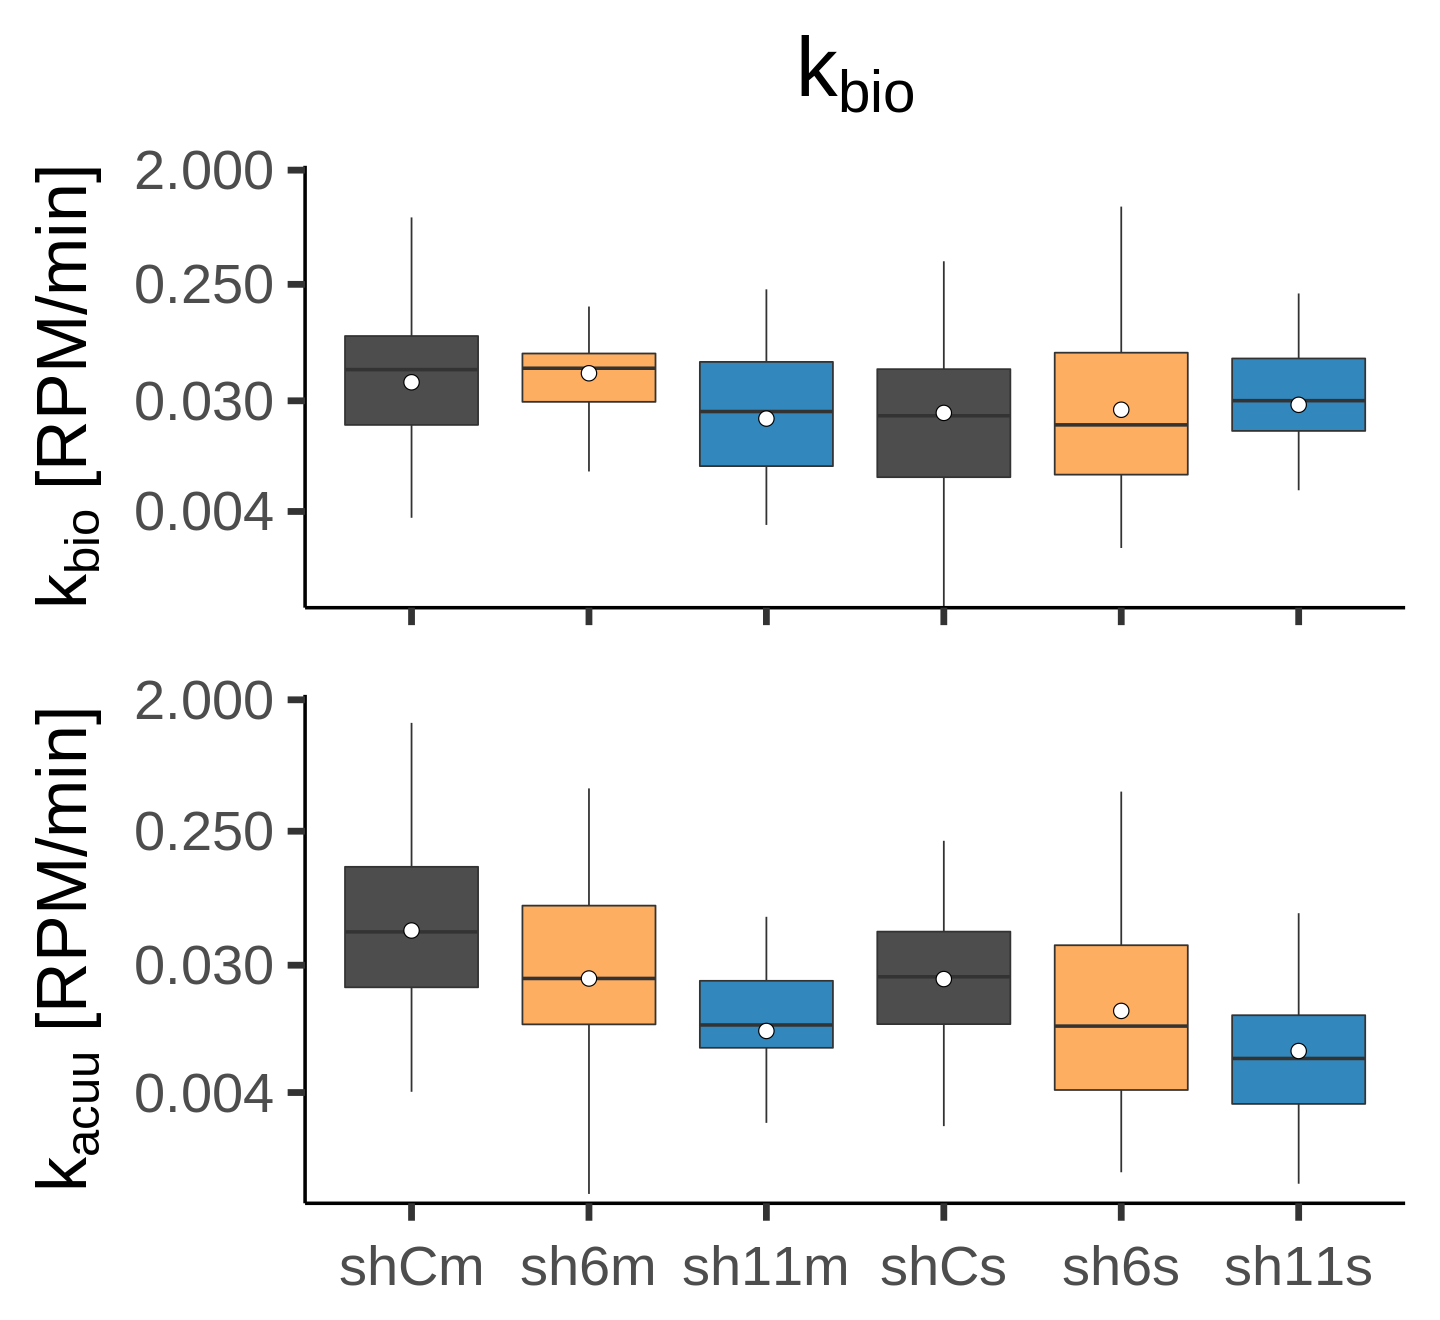

In [98]:
options(repr.plot.width=10, repr.plot.height=5)

bio <- ggplot(test.bio, aes(x=sample, y=k.bio)) + 
    theme_bw(base_size = 42) +
    ggtitle(expression(k[bio])) +
    theme(plot.title = element_text(hjust = '0.5', size=50)) +
    theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
              panel.background = element_blank(), panel.border = element_blank()) +
    theme(axis.line = element_line(colour = "black", size = 1), 
              axis.title.x = element_blank(), axis.text.x = element_blank()) +
    scale_y_continuous(trans = 'log2', breaks=c(0.004, 0.03, 0.25,2))+
    coord_cartesian(ylim=c(0.001, 1.5)) +
    ylab(expression('k'[bio]*' [RPM/min]'))  +
    scale_x_discrete(limits=c("shCm", "sh6m","sh11m", "shCs", "sh6s", "sh11s")) +
    geom_boxplot(notch=FALSE,outlier.shape=NA, fill=c(col_shgfp,col_sh6,col_sh11, col_shgfp, col_sh6, col_sh11)) +
    #geom_dotplot(binaxis = "y", stackdir = "center", position = "dodge", binwidth = 0.004, alpha=0.2)+
    stat_summary(fun=mean, colour="black", fill="white", geom="point", 
                     shape=21, size=4,show.legend = FALSE)

accu <- ggplot(test.accu, aes(x=sample, y=k.accu)) + 
    theme_bw(base_size = 42) +
    #ggtitle(expression(k[accu])) +
    #theme(plot.title = element_text(hjust = '0.5', size=50)) +
    theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
              panel.background = element_blank(), panel.border = element_blank()) +
    theme(axis.line = element_line(colour = "black", size = 1), 
              axis.title.x = element_blank(), axis.text.x = element_text(angle = 0, vjust = 0, hjust=0.5)) +
    scale_y_continuous(trans = 'log2', breaks=c(0.004, 0.03, 0.25,2)) + # if I add limits here, it will alter the data
    coord_cartesian(ylim=c(0.001,1.5)) + # add limits here, it will keep the data but cut the window
    ylab(expression('k'[acuu]*' [RPM/min]'))  +
    scale_x_discrete(limits=c("shCm", "sh6m", "sh11m", "shCs", "sh6s", "sh11s")) +
    geom_boxplot(notch=FALSE,outlier.shape=NA, fill=c(col_shgfp,col_sh6,col_sh11, col_shgfp, col_sh6,col_sh11)) +
    #geom_dotplot(binaxis = "y", stackdir = "center", position = "dodge", binwidth = 0.001) 
    stat_summary(fun=mean, colour="black", fill="white", geom="point", 
                     shape=21, size=4,show.legend = FALSE)


options(repr.plot.width=12, repr.plot.height=11)
plot_grid(bio, accu, nrow=2, rel_heights=c(1,1))

## stats kbio

In [42]:
head(test.bio)

,arm.name,k.bio,sample
,<chr>,<dbl>,<chr>
1,let-7d-5p,0.19140943,shCm
2,let-7i-5p,0.03908045,shCm
3,miR-106b-3p,0.09579889,shCm
6,miR-151a-3p,0.06504392,shCm
7,miR-15b-3p,0.10288146,shCm
8,miR-17-5p,0.06579200,shCm


In [43]:
# Compute the analysis of variance
res.aov <- aov(k.bio ~ sample, data = test.bio)
# Summary of the analysis
summary(res.aov)

TukeyHSD(res.aov)

             Df Sum Sq Mean Sq F value Pr(>F)
sample        5   0.43 0.08598   0.624  0.682
Residuals   111  15.30 0.13784               

  Tukey multiple comparisons of means
    95% family-wise confidence level

Fit: aov(formula = k.bio ~ sample, data = test.bio)

$sample
                    diff        lwr       upr     p adj
sh11s-sh11m  0.085054417 -0.2864508 0.4565597 0.9854683
sh6m-sh11m   0.061066507 -0.2712179 0.3933509 0.9947099
sh6s-sh11m   0.188864976 -0.1361156 0.5138455 0.5442758
shCm-sh11m   0.052583470 -0.2838289 0.3889958 0.9975380
shCs-sh11m   0.079277921 -0.2665747 0.4251305 0.9853883
sh6m-sh11s  -0.023987910 -0.3954932 0.3475174 0.9999673
sh6s-sh11s   0.103810559 -0.2611766 0.4687977 0.9623409
shCm-sh11s  -0.032470948 -0.4076729 0.3427310 0.9998610
shCs-sh11s  -0.005776496 -0.3894655 0.3779125 1.0000000
sh6s-sh6m    0.127798469 -0.1971821 0.4527790 0.8633530
shCm-sh6m   -0.008483038 -0.3448954 0.3279293 0.9999997
shCs-sh6m    0.018211414 -0.3276412 0.3640640 0.9999881
shCm-sh6s   -0.136281507 -0.4654816 0.1929186 0.8357223
shCs-sh6s   -0.109587055 -0.4484284 0.2292543 0.9357590
shCs-shCm    0.02669445

## stats kaccu

In [44]:
# Compute the analysis of variance
res.aov <- aov(k.accu ~ sample, data = test.accu)
# Summary of the analysis
summary(res.aov)

TukeyHSD(res.aov)

             Df Sum Sq Mean Sq F value   Pr(>F)    
sample        5  0.512 0.10245   4.779 0.000431 ***
Residuals   156  3.344 0.02144                     
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

  Tukey multiple comparisons of means
    95% family-wise confidence level

Fit: aov(formula = k.accu ~ sample, data = test.accu)

$sample
                    diff         lwr         upr     p adj
sh11s-sh11m  0.001374029 -0.12368038  0.12642844 1.0000000
sh6m-sh11m   0.056121911 -0.05828452  0.17052834 0.7176342
sh6s-sh11m   0.026940740 -0.09139833  0.14527981 0.9862461
shCm-sh11m   0.158557494  0.04499291  0.27212207 0.0012111
shCs-sh11m   0.023833295 -0.09146625  0.13913284 0.9911472
sh6m-sh11s   0.054747882 -0.06545491  0.17495067 0.7768124
sh6s-sh11s   0.025566711 -0.09838495  0.14951837 0.9912344
shCm-sh11s   0.157183465  0.03778165  0.27658528 0.0028133
shCs-sh11s   0.022459266 -0.09859388  0.14351241 0.9946398
sh6s-sh6m   -0.029181171 -0.14238118  0.08401883 0.9760582
shCm-sh6m    0.102435583 -0.00576340  0.21063457 0.0747647
shCs-sh6m   -0.032288616 -0.14230722  0.07772998 0.9581180
shCm-sh6s    0.131616754  0.01926764  0.24396587 0.0115887
shCs-sh6s   -0.003107445 -0.1172100